In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import *

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 18:54:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/07 18:54:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/07 18:54:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/07 18:54:25 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
data_loc = "../data/tables/"

consumer_fraud = spark.read.option("header", "true").csv(data_loc+"consumer_fraud_probability.csv")
merchant_fraud = spark.read.option("header", "true").csv(data_loc+"merchant_fraud_probability.csv")
raw_join = spark.read.parquet("../data/curated/raw_join_internal_table/")

<h2>1. Unsupervised Learning: to classify each instance into low, medium and high level of fraud probability</h2>

<h3>1.1 Determine whether an instance is an outlier based on dollor value (assumption: an outlier may be a fraud instance)</h3>

<h4>1.1.1 Extract and aggregate the dollar value for each user </h4>

In [3]:
# find the average dollor value for each user on each date
raw_join_date = (raw_join.groupBy("user_id", "order_datetime")
                        .agg(avg("dollar_value").alias("dollar_value_average"))
                        .orderBy("user_id"))

In [4]:
# find the average and standard deviation of dollor value for each user
join_std = (raw_join_date.groupBy("user_id")\
                         .agg(stddev_pop("dollar_value_average").alias("dollar_std"),
                              avg("dollar_value_average").alias("dollar_mean")))

<h4>1.1.2 Determine whether an instance is an outlier for corresponding user (0 is not outlier; 1 is outlier) </h4>

In [5]:
raw_join_outlier = (raw_join_date.join(join_std, "user_id", "left")
                   .withColumn("isOutlier",
                                F.when((abs(col("dollar_value_average") - col("dollar_mean")) <= 3 * col("dollar_std")), 0).otherwise(1))
                   .drop("dollar_mean")
                   .drop("dollar_std")
                   .drop("dollar_value_average"))

In [6]:
raw_join_outlier

22/10/07 18:54:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 18:55:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 18:55:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 18:56:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


user_id,order_datetime,isOutlier
1,2022-05-23,0
1,2021-07-30,0
1,2022-08-21,0
1,2021-09-12,0
1,2022-10-25,0
1,2021-08-21,0
1,2022-02-06,0
1,2021-05-30,0
1,2021-07-13,0
1,2021-05-20,0


<h3>1.2. Join with consumer fraud probability</h3>

In [7]:
consumer_fraud = consumer_fraud.withColumnRenamed("user_id", "user_id_alt")
consumer_fraud = consumer_fraud.withColumnRenamed("order_datetime", "order_datetime_alt")

In [8]:
raw_join_outlier.createOrReplaceTempView("consumer")
consumer_fraud.createOrReplaceTempView("probability")

consumer_prob = spark.sql("""
SELECT 
    user_id, order_datetime, fraud_probability, isOutlier
FROM 
    consumer
LEFT JOIN 
    probability
ON 
    consumer.user_id == probability.user_id_alt
AND 
    consumer.order_datetime == probability.order_datetime_alt
""")


In [9]:
# fill the non exists probability with 0.1
consumer_prob = consumer_prob.withColumn("fraud_probability", 
                            F.when((col("fraud_probability").isNull()), 0.1).otherwise(F.col("fraud_probability")))

In [10]:
# convert data type of features to ensure they can be vectorize
consumer_prob = consumer_prob.withColumn("fraud_probability", F.col("fraud_probability").cast("float"))

<h3>1.3. Vectorize and standardize the features to ensure they are suitible for the clustering model (k-means)</h3>

In [11]:
# vectorized the features for model training
from pyspark.ml.feature import VectorAssembler

features = 'features'
input_cols = ["fraud_probability", "isOutlier"]

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

consumer_transformed = assembler.transform(consumer_prob.dropna('any'))

In [12]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(consumer_transformed)

consumer_transformed = scalerModel.transform(consumer_transformed)

22/10/07 18:56:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 18:56:48 WARN TransportClientFactory: DNS resolution succeed for mugis-air/192.168.20.10:62019 took 5006 ms


22/10/07 18:56:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [13]:
from pyspark.ml.feature import VectorIndexer

featureIndexer = VectorIndexer(inputCol="scaledFeatures", \
                               outputCol="indexedFeatures",\
                               maxCategories=3165
).fit(consumer_transformed)

consumer_transformed = featureIndexer.transform(consumer_transformed)

22/10/07 18:57:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 18:57:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<h3>1.4. Modelling using k-means and clustering </h3>

In [14]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='indexedFeatures', k=3)
model = kmeans.fit(consumer_transformed.select("indexedFeatures"))
consumer_kmean = model.transform(consumer_transformed)
consumer_kmean = consumer_kmean.withColumnRenamed("prediction", "fraud_group")

22/10/07 18:58:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 18:58:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 18:59:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 18:59:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:01:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:01:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<h3>1.5. Check the clustering is followed by the assumption </h3>

In [15]:
consumer_check = consumer_kmean.groupBy("fraud_group").agg(mean("fraud_probability").alias("mean_prob"), 
                                          sum("isOutlier").alias("outlier_amount"), 
                                          count("isOutlier").alias("total_instance"))

In [16]:
consumer_check = (consumer_check.withColumn("outlier_rate", F.col("outlier_amount")/F.col("total_instance"))
                               .drop(col("outlier_amount"))
                               .drop(col("total_instance")))

In [17]:
consumer_check

22/10/07 19:02:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:02:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:02:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:03:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


fraud_group,mean_prob,outlier_rate
1,43.73568163262692,0.7801480191554201
2,12.78263203896653,0.6509681654085986
0,0.10000000149011612,0.014182568866228954


In [38]:
prob_group0 = (consumer_check.where(col("fraud_group") == 0).collect())[0].mean_prob
prob_group1 = (consumer_check.where(col("fraud_group") == 1).collect())[0].mean_prob
prob_group2 = (consumer_check.where(col("fraud_group") == 2).collect())[0].mean_prob

22/10/07 19:34:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:34:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:35:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:35:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:37:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:37:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [40]:
if prob_group0 > prob_group1:
    consumer_kmean = consumer_kmean.withColumn("fraud_group", F.when(F.col("fraud_group") == 0, 1).otherwise(F.when(F.col("fraud_group") == 1, 0).otherwise(F.col("fraud_group"))))
if prob_group1 > prob_group2:
    consumer_kmean = consumer_kmean.withColumn("fraud_group", F.when(F.col("fraud_group") == 1, 2).otherwise(F.when(F.col("fraud_group") == 2, 1).otherwise(F.col("fraud_group"))))

2


<h3>1.6. Add the fraud_group feature to the internal joined dataset</h3>

In [42]:
add_fraud = raw_join.join(consumer_kmean, ["user_id", "order_datetime"], "left")

In [43]:
add_fraud = add_fraud.drop("fraud_probability", "isOutlier", "features", "scaledFeatures", "indexedFeatures")

<h2>2. Outlier removal</h2>

<h3>2.1 Get distribution for each revenue level</h3>

In [44]:
import seaborn as sns
sns.set(style = 'whitegrid')
my_order = ["a", "b", "c", "d", "e"]

22/10/07 19:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

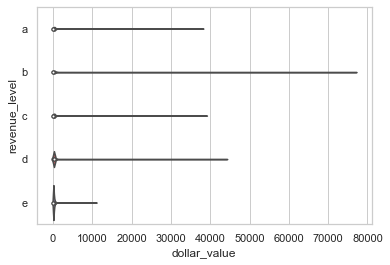

In [45]:
sns.violinplot(data=add_fraud.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level", order=my_order)

22/10/07 19:47:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

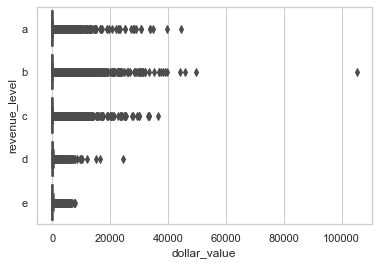

In [46]:
sns.boxplot(data=add_fraud.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level", order=my_order)

<h4>2.1.1 Remove outliers based on standard deviation</h4>

In [47]:
rev_std = (add_fraud.groupBy("revenue_level").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                             avg("dollar_value").alias("dollar_value_mean")))
rev_std

22/10/07 19:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:50:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:51:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:51:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


revenue_level,dollar_value_std,dollar_value_mean
e,399.0600030109279,205.81060473911995
d,681.0178374382822,272.261558375609
c,439.15886606318264,136.61671509843808
b,607.8880371974757,197.4955404638425
a,366.0590821739542,142.19102393900536


In [48]:
total = add_fraud.count()
rev_sdf = (add_fraud.join(rev_std, "revenue_level", "left")
               .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
               .drop("dollar_value_mean")
               .drop("dollar_value_std"))
print(f"Outliers based on revenue band removed: {total - rev_sdf.count()}")

22/10/07 19:53:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:53:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:54:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 19:54:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Outliers based on revenue band removed: 133177


<h4>2.1.2 Check distribution</h4>

22/10/07 19:57:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

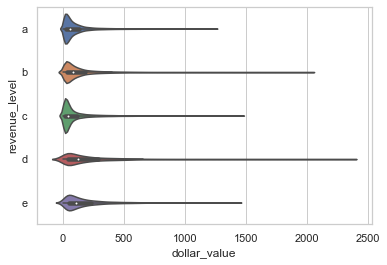

In [49]:
sns.violinplot(data=rev_sdf.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level", order=my_order)

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

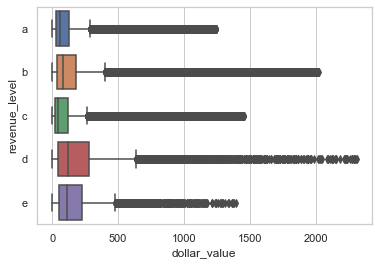

In [50]:
sns.boxplot(data=rev_sdf.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level", order=my_order)

<h3>2.2 Get distribution of each merchant</h3>

In [51]:
merch_std = (rev_sdf.groupBy("merchant_name").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                                  avg("dollar_value").alias("dollar_value_mean")))
merch_std

22/10/07 20:06:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


merchant_name,dollar_value_std,dollar_value_mean
Donec Luctus Indu...,130.55650157165087,343.7164090501806
Dictum Mi Incorpo...,368.6617885233332,471.07965026653414
Amet Nulla Ltd,54.82924410856011,86.38047478621884
Vel Turpis Company,206.33110261321298,464.72620295222833
Montes Limited,439.1076561117737,605.259061619393
Semper Incorporated,60.33157881454652,103.80269405622981
Mollis Integer Co...,35.72032434616903,35.39825775749802
Porttitor Eros In...,64.63472631463996,99.96567570503576
Malesuada Vel Ltd,201.89377133366608,242.1083337475958
Arcu Vestibulum C...,193.4276467747397,301.19744865722646


In [52]:
total = rev_sdf.count()
merch_sdf = (rev_sdf.join(merch_std, "merchant_name", "left")
                   .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
                   .drop("dollar_value_mean")
                   .drop("dollar_value_std"))
print(f"Outliers based on merchant removed: {total - merch_sdf.count()}")

22/10/07 20:08:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 20:08:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 20:10:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 20:10:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Outliers based on merchant removed: 175313


In [53]:
merch_sdf.write.parquet("../data/curated/merchant_consumer_info")

22/10/07 20:13:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 20:13:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
